# XGBoost for Time Series Data
## Use Case: Electrical Demand Forecasting 
This example predicts electrical demand using data from the Electric Reliability Council of Texas: http://www.ercot.com/gridinfo/load/load_hist/

## Part 1: Prepare Data

This notebook expects a dataset with two columns:
1. An input datetime column for the time series
2. A numeric target column that we are trying to predict

### Import Datasets

**User Action:** Set `dataset_path` to the relative path of your input CSV file.

Reads the CSV file into a pandas dataframe

Displays the first and last three rows of the dataset

In [1]:
dataset_path = '../datasets/ERCOT_Hourly_Load_Data_2002-2016.csv'

import pandas as pd
orig_data = pd.read_csv(dataset_path)

import numpy as np
orig_data.iloc[np.r_[0:3, -3:0]]

,Hour_End,ERCOT
0,2002-01-01 01:00:00.003,29670.162911
1,2002-01-01 01:59:59.997,29136.833703
2,2002-01-01 03:00:00.000,28703.905525
131493,2016-12-31 22:00:00.003,32537.966593
131494,2016-12-31 22:59:59.997,31393.781071
131495,2017-01-01 00:00:00.000,30351.798730


### Specify Input Datetime, Target Numeric Columns and Validate Data Types

**User Action:** Set the following variables based on the characteristics of your input dataset:
  - `datetime_col`: name of the column containing the datetime of the row entry
  - `target_col`: name of the column containing the target numeric value that we are trying to predict

Actions:
1. Converts `datetime_col` to datetime format if necessary
2. Validates the specified columns are of the expected format

Displays the names of the columns that are being used

In [2]:
datetime_col = 'Hour_End'
target_col = 'ERCOT'

# Validate column orig_data types
from pandas.api.types import is_datetime64_any_dtype, is_numeric_dtype
try:
    assert is_datetime64_any_dtype(orig_data[datetime_col])
except AssertionError:
    orig_data[datetime_col] = pd.to_datetime(orig_data[datetime_col])
    assert is_datetime64_any_dtype(orig_data[datetime_col]), "Column {} is of type <{}> but expected a <datetime>.".format(datetime_col, orig_data[datetime_col].dtypes)
assert is_numeric_dtype(orig_data[target_col]), "Column {} is of type <{}> but expected a <numeric>.".format(target_col, orig_data[target_col].dtypes)

print("Using input datetime column '{}'".format(datetime_col))
print("Using target numeric column '{}'".format(target_col))

Using input datetime column 'Hour_End'
Using target numeric column 'ERCOT'


### Split Datetime Column into Date Features

Given the datetime column, extracts the following into separate columns:
- `'Year'`: The year of the datetime
- `'Week'`: The week ordinal of the year
- `'Monday'->'Sunday'`: One-hot encoding of the name of the day in a week
- `'Hour'`: The hour of the datetime

Displays the first and last three rows of the resulting dataset

In [3]:
input_data = pd.DataFrame()

# Round the datetime to the nearest hour so that hour extraction is correct
input_data[datetime_col] = orig_data[datetime_col].dt.round("H")

# Extract numeric year and week from the datetime
input_data['Year'] = orig_data[datetime_col].dt.year
input_data['Week'] = orig_data[datetime_col].dt.week

# Extract the weekday_name and one-hot encode
weekdays = orig_data[datetime_col].dt.weekday_name
onehot_weekdays = pd.get_dummies(weekdays)
input_data = pd.concat([input_data, onehot_weekdays], axis=1)

# Extract the hour of the datetime and add the target column
input_data['Hour'] = input_data[datetime_col].dt.hour
input_data[target_col] = orig_data[target_col]

input_data.iloc[np.r_[0:3, -3:0]]

,Hour_End,Year,Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Hour,ERCOT
0,2002-01-01 01:00:00,2002,1,0,0,0,0,0,1,0,1,29670.162911
1,2002-01-01 02:00:00,2002,1,0,0,0,0,0,1,0,2,29136.833703
2,2002-01-01 03:00:00,2002,1,0,0,0,0,0,1,0,3,28703.905525
131493,2016-12-31 22:00:00,2016,52,0,0,1,0,0,0,0,22,32537.966593
131494,2016-12-31 23:00:00,2016,52,0,0,1,0,0,0,0,23,31393.781071
131495,2017-01-01 00:00:00,2017,52,0,0,0,1,0,0,0,0,30351.798730


### Drop Rows with Null Values

Drops rows that have any null values to avoid training and validation errors

Displays number of rows dropped

In [4]:
clean_input_data = input_data.dropna()

print("Dropped {} rows with null values.".format(input_data.shape[0] - clean_input_data.shape[0]))

Dropped 1 rows with null values.


### Split data into Train and Test Sets Based on a Cutoff Datetime

**User Action:** Set the variable `cutoff_time` to the date/datetime value (in [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) format) of the custoff that will be used to split training and testing sets.

Splits dataset into two separate `train` and `test` datasets

Displays the first and last three rows of the resulting datasets

In [5]:
cutoff_time = '2016-01-01'

# Split train and test along cutoff_time
cutoff_datetime = pd.to_datetime(cutoff_time)
train = clean_input_data[clean_input_data[datetime_col] < cutoff_datetime]
test = clean_input_data[clean_input_data[datetime_col] >= cutoff_datetime]

# Drop datetime column but save it for later
train_dates = train[datetime_col]
test_dates = test[datetime_col]
train = train.drop(datetime_col, axis=1)
test = test.drop(datetime_col, axis=1)

from IPython.display import display
print('Training set:')
display(train.iloc[np.r_[0:3, -3:0]])

print('Test set:')
display(test.iloc[np.r_[0:3, -3:0]])

Training set:


,Year,Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Hour,ERCOT
0,2002,1,0,0,0,0,0,1,0,1,29670.162911
1,2002,1,0,0,0,0,0,1,0,2,29136.833703
2,2002,1,0,0,0,0,0,1,0,3,28703.905525
122708,2015,53,0,0,0,0,1,0,0,21,38075.677924
122709,2015,53,0,0,0,0,1,0,0,22,36929.975190
122710,2015,53,0,0,0,0,1,0,0,23,35660.210526


Test set:


,Year,Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Hour,ERCOT
122711,2016,53,1,0,0,0,0,0,0,0,34677.378280
122712,2016,53,1,0,0,0,0,0,0,1,33852.758587
122713,2016,53,1,0,0,0,0,0,0,2,33434.097940
131493,2016,52,0,0,1,0,0,0,0,22,32537.966593
131494,2016,52,0,0,1,0,0,0,0,23,31393.781071
131495,2017,52,0,0,0,1,0,0,0,0,30351.798730


### Split the Training Data Features and Columns

Splits `train` into input `X_train` dataframe and output `y_train` series

Displays the first and last three rows of both

In [6]:
y_train = train[target_col]
X_train = train.drop([target_col], axis = 1)

print('X_train:')
display(X_train.iloc[np.r_[0:3, -3:0]])

print('y_train:')
display(y_train.iloc[np.r_[0:3, -3:0]])

X_train:


,Year,Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Hour
0,2002,1,0,0,0,0,0,1,0,1
1,2002,1,0,0,0,0,0,1,0,2
2,2002,1,0,0,0,0,0,1,0,3
122708,2015,53,0,0,0,0,1,0,0,21
122709,2015,53,0,0,0,0,1,0,0,22
122710,2015,53,0,0,0,0,1,0,0,23


y_train:


0         29670.162911
1         29136.833703
2         28703.905525
122708    38075.677924
122709    36929.975190
122710    35660.210526
Name: ERCOT, dtype: float64

### Split the Test Data Features and Columns

Splits `test` into input `X_test` dataframe and output `y_test` series

Displays the first and last three rows of both

In [7]:
y_test = test[target_col]
X_test = test.drop([target_col], axis = 1)

print('X_test:')
display(X_test.iloc[np.r_[0:3, -3:0]])

print('y_test:')
display(y_test.iloc[np.r_[0:3, -3:0]])

X_test:


,Year,Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Hour
122711,2016,53,1,0,0,0,0,0,0,0
122712,2016,53,1,0,0,0,0,0,0,1
122713,2016,53,1,0,0,0,0,0,0,2
131493,2016,52,0,0,1,0,0,0,0,22
131494,2016,52,0,0,1,0,0,0,0,23
131495,2017,52,0,0,0,1,0,0,0,0


y_test:


122711    34677.378280
122712    33852.758587
122713    33434.097940
131493    32537.966593
131494    31393.781071
131495    30351.798730
Name: ERCOT, dtype: float64

## Part 2: Train XGBoost Model

### Grid Search Cross-Valdation with Gradient Boosting Regressor

**User Action:** Set the `tuned_parameters` used by [Grid Search Cross-Validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Conducts exhaustive search over specified parameter values for [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)

Displays cross-validation log and resulting `GridSearchCV` object

In [8]:
tuned_parameters = {
    'n_estimators': [100, 150, 200, 250, 300], 
    'learning_rate': [0.10, 0.15, 0.20, 0.25, 0.30],
}

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

clf = GridSearchCV(estimator = XGBRegressor(), param_grid = tuned_parameters, cv=2, iid=False, n_jobs=-1)
# to see output during run, add:, verbose=2

clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3], 'n_estimators': [100, 150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Print Best Parameters from Grid Search

In [9]:
best_params = clf.best_params_
best_params

{'learning_rate': 0.25, 'n_estimators': 250}

### Print Best Model from Grid Search

In [10]:
best_model = clf.best_estimator_
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.25, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Optional: Save Model to DSX

In [11]:
from dsx_ml.ml import save

save(name='XGBoost Electrical Demand',
     model=best_model,
     x_test=pd.DataFrame(X_test),
     y_test=pd.DataFrame(y_test),
     algorithm_type='Regression',
     source='XGBoost for Time Series Data - Electrical Demand.ipynb',
     description='XGBoost Model Trained with Cross-Validation on Texas Electrical Demand Data')

# NBVAL_SKIP

## Part 3: Predict on Test Data

- Use `best_model` from previous step to predict on `X_test`
- Saves prediction to series `y_pred` with name `target_col+'_pred'`
- Displays first 5 rows of `y_pred` series

In [12]:
y_pred_np = best_model.predict(X_test)

# Convert numpy array to pandas series
y_pred = pd.Series(y_pred_np, index=y_test.index, name=target_col+'_pred')

# Print
print(y_pred.name+':')
y_pred.head()

ERCOT_pred:


122711    35287.832031
122712    34090.160156
122713    33355.007812
122714    32753.421875
122715    32652.539062
Name: ERCOT_pred, dtype: float32

### Concatenate Real and Predicted Values into Single Dataframe, Save to CSV File

**User Action:** Set `output_dataset_path` to the file path where you want to save the CSV file

Create a dataframe with columns `test_dates`, `y_test`, and `y_pred` and index `datetime_col`

In [13]:
output_dataset_path = '../datasets/ERCOT_Predictions_2016.csv'

real_pred_values = pd.concat([test_dates, y_test, y_pred], axis=1).set_index(datetime_col)
real_pred_values.to_csv(output_dataset_path)
real_pred_values.head()

,ERCOT,ERCOT_pred
Hour_End,,
2016-01-01 00:00:00,34677.378280,35287.832031
2016-01-01 01:00:00,33852.758587,34090.160156
2016-01-01 02:00:00,33434.097940,33355.007812
2016-01-01 03:00:00,33099.066023,32753.421875
2016-01-01 04:00:00,33053.807611,32652.539062


## Part 4: Evaluate Prediciton 

### Calculate Root Mean Square Error

Calculates RMSE between `y_test` and `y_pred` using [`sklearn.metrics.mean_squared_error`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [14]:
from sklearn.metrics import mean_squared_error
print("Root Mean Square Error of the model prediction is: ", round((mean_squared_error(y_test, y_pred))**0.5, 1))

Root Mean Square Error of the model prediction is:  4347.8


### Calculate Mean Absolute  Error

In [15]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error of the model prediction is: ", round((mean_absolute_error(y_test, y_pred)), 1))

Mean Absolute Error of the model prediction is:  3297.4


### Calculate Mean Absolute Percentage Error

Calculates MAPE between `y_test` and `y_pred` using [a solution from stats.stackexchange](https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/294069#294069)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Mean Absolute Percentage Error of the model prediction is: {}%".format(round(mean_absolute_percentage_error(y_test, y_pred),1)))

Mean Absolute Percentage Error of the model prediction is: 8.2%


### Group Data by Day and Calculate Daily Mean Values

Given the `real_pred_values` dataset, extract the day of the timetamp into column `'Date'`

Group rows on the `'Date'` column, then calculate the daily means of the groups for the real and predicted values. Set the dataframe index to `'Date'`.

Displays first 5 rows of the dataframe

In [17]:
date_real_pred_values = real_pred_values.copy()
date_real_pred_values['Date'] = date_real_pred_values.index.date
daily_values = date_real_pred_values.groupby(['Date'], as_index=False).mean().set_index('Date')
daily_values.head()

,ERCOT,ERCOT_pred
Date,,
2016-01-01,37106.467108,37535.105469
2016-01-02,38040.142889,36767.617188
2016-01-03,35507.063355,37134.750000
2016-01-04,38546.356095,43529.074219
2016-01-05,40178.717859,42655.468750


### Plot Daily Mean Values for Comparison

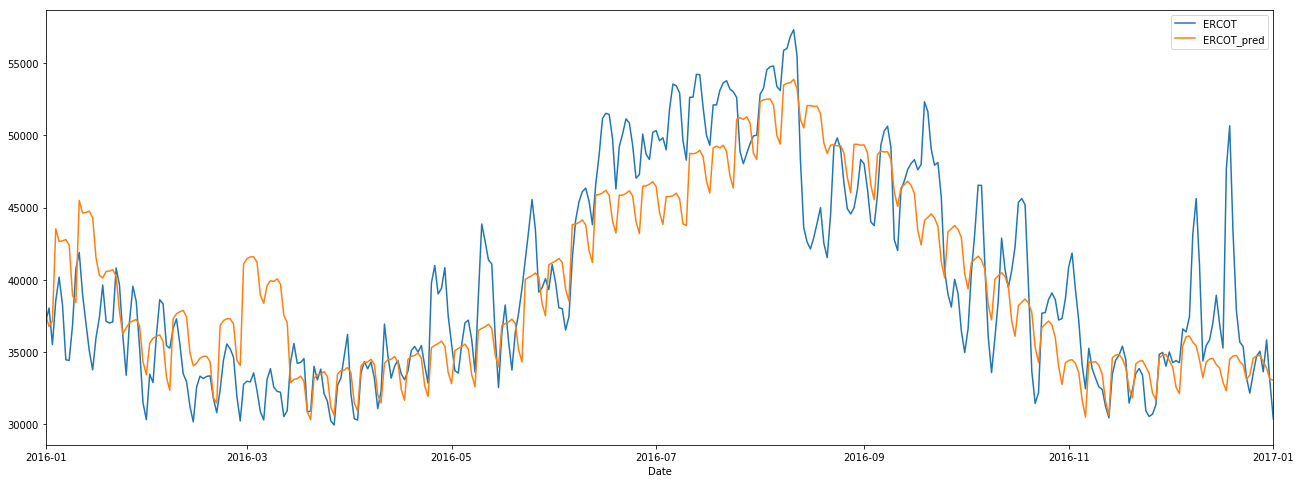

In [18]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 22, 8

daily_values.plot()

### Plot Zoom Chart of Real and Predicted Values using D3

#### Define `plot_zoom_chart` function

Inspiration: https://www.stefaanlippens.net/jupyter-custom-d3-visualization.html

In [19]:
import os
from IPython.display import display, HTML, Javascript

def plot_zoom_chart(data, time_col='time', plot_height=500, nav_height=100):
    
    # Process data and convert to JSON
    renamed_data = data.reset_index().rename(columns={time_col:'time'})
    renamed_data['time'] = pd.to_datetime(renamed_data['time'])
    rows = renamed_data.to_json(orient='records')
    
    # Load D3 v4
    display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v4.min'}});"))
    
    # Load zoom-graph.js from filesystem
    scripts_path = '../scripts/'
    display(Javascript(filename=scripts_path+'zoom-graph.js'))
    
    # Create HTML elements to hold different sections of the chart
    display(HTML("""
    <div id="chartLegend" class="legend d-flex justify-content-end align-items-middle">&nbsp;</div>
    <svg id="chartZoomed" width="100%" height="{}px" />
    <svg id="chartNav" width="100%" height="{}px" />
    """.format(plot_height, nav_height)))
    
    # Plot the ZoomGraph of the dataset
    display(Javascript("""
    require(['ZoomGraph'], function(ZoomGraph) {
        $(function () {
            var chart = new ZoomGraph('chartNav', 'chartZoomed', 'chartLegend', %s);
            $(window).resize(function () {
                if (chart) {
                    chart.redraw();
                }
            });
        });
    });
    """ % rows))

#### Call `plot_zoom_chart` on `real_pred_values`, using `datetime_col` for time index

In [20]:
plot_zoom_chart(real_pred_values, datetime_col)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Developed by Data Science Elite Team, IBM Analytics:
- Aakanksha Joshi - Data Science and Machine Learning Intern (Summer 2018)
- David Thomason - Software Engineer
- Alan Villalobos - Data Journalist

#### Copyright (c) 2018 IBM Corporation